# Statistical shape and appearance modelling with pyssam

In [4]:
import pyssam

In [5]:
from copy import copy
import matplotlib.pyplot as plt
import numpy as np

First, we source landmark data to use in our shape model

In [6]:
LANDMARK_DIR = "../../exampleData/gamesData/"
XR_DIR = "../../exampleData/drrs/"
# Get directories for DRR and landmark data
origin_dir_list = glob(f"{XR_DIR}/origins/origins/drr*.md")
spacing_dir_list = glob(f"{XR_DIR}/*/drr*.md")
im_dir_list = glob(f"{XR_DIR}/*/drr*.png")
origin_dir_list.sort()
spacing_dir_list.sort()
im_dir_list.sort()
# check that user has declared correct directory
patientIDs = [i.split("/")[-1].replace(".png", "")[-4:] for i in im_dir_list]
landmark_dir_list = glob(f"{LANDMARK_DIR}/landmarks*.csv")
landmark_dir_list = sorted(
  landmark_dir_list, key=lambda x: int(x.replace(".csv", "")[-4:])
)
# used to align drrs and landmarks
trans_dirs = glob(f"{XR_DIR}/transforms/transformParams_case*_m_*.dat")
trans_dirs.sort()

if (
  len(im_dir_list) == 0
  or len(origin_dir_list) == 0
  or len(landmark_dir_list) == 0
  or len(spacing_dir_list) == 0
):
  raise AssertionError(
    "ERROR: The directories you have declared are empty.",
    "\nPlease check your input arguments.",
  )

landmark_offset = np.vstack(
  [np.loadtxt(t, skiprows=1, max_rows=1) for t in trans_dirs]
)
# read data
origin = np.vstack([np.loadtxt(o, skiprows=1) for o in origin_dir_list])
spacing = np.vstack([np.loadtxt(o, skiprows=1) for o in spacing_dir_list])
# load x-rays into a stacked array,
# switch so shape is (num patients, x pixel, y pixel)
img_all = np.rollaxis(np.dstack([pyssam.utils.loadXR(o) for o in im_dir_list]), 2, 0)
landmark_coordinates = np.array(
  [np.loadtxt(l, delimiter=",") for l in landmark_dir_list]
)

# offset centered coordinates to same reference frame as CT data
landmark_align_to_projection = (
  landmark_coordinates + landmark_offset[:, np.newaxis]
)

In [7]:
appearance_helper = pyssam.utils.AppearanceFromXray(
    landmark_align_to_projection, 
    img_all, 
    origin, 
    spacing
)

## Initialising the model

Here we convert to landmark coordinates into a parameterised shape model. We first initialise the class, which handles all pre-processing. Then, we can compute the shape model components and mean population shape

In [8]:
ssam_obj = pyssam.SSAM(landmark_coordinates, appearance_helper.appearance_base)
ssam_obj.create_pca_model(ssam_obj.shape_appearance_columns)
mean_shape_appearance_columnvector = ssam_obj.compute_dataset_mean()
mean_appearance_columnvector = mean_shape_appearance_columnvector.reshape(-1, 4)[:, 3]
shape_model_components = ssam_obj.pca_model_components
mean_shape_columnvector = ssam_obj.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 3)

Reduced to 27 components from 48 for 90.0% variation


## Plotting and analysis

In [9]:
# Define some plotting functions

def plot_cumulative_variance(explained_variance, target_variance=-1):
    number_of_components = np.arange(0, len(explained_variance))+1
    fig, ax = plt.subplots(1,1)
    color = "blue"
    ax.plot(number_of_components, explained_variance*100.0, marker="o", ms=2, color=color, mec=color, mfc=color)
    if target_variance > 0.0:
        ax.axhline(target_variance*100.0)
    
    ax.set_ylabel("Variance [%]")
    ax.set_xlabel("Number of components")
    ax.grid(axis="x")
    plt.show()
    
def plot_ssam_modes(
  mean_shape_appearance_columnvector, 
  mean_shape, 
  original_shape_parameter_vector,
  shape_model_components,
  show_difference=True,
  mode_to_plot=0,
):
  print(f"explained variance is {ssam_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

  weights = [-2, 0, 2]
  fig, ax = plt.subplots(1, 3)
  for j, weights_i in enumerate(weights):
    shape_parameter_vector = copy(original_shape_parameter_vector)
    shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_morphed = ssam_obj.morph_model(
        mean_shape_appearance_columnvector, 
        shape_model_components, 
        shape_parameter_vector
    ).reshape(-1, 4)
    mean_appearance_columnvector = mean_shape_appearance_columnvector.reshape(-1, 4)[:, 3]
    mode_i_appearance = mode_i_morphed[:, 3]
    
    offset_appearance = (mean_appearance_columnvector - mode_i_appearance)
    if weights_i != 0 and show_difference:
      ax[j].scatter(
        mode_i_morphed[:, 0],
        mode_i_morphed[:, 2],
        c=offset_appearance,
        cmap="seismic",
        vmin=-1,
        vmax=1,
        s=1,
      )
    else:
        ax[j].scatter(
        mode_i_morphed[:, 0],
        mode_i_morphed[:, 2],
        c=mode_i_appearance,
        cmap="gray",
        s=1,
        )
    if weights_i == 0:
        ax[j].set_title("mean shape")
    else:
        ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")

    ax[j].axis('off')
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  plt.show()




Generally, the first part in assessing the model once trained is visualising how the explained variance changes with an increasing number of modes. If few modes are required, it means it will be much simpler to fit the SSM to an image.

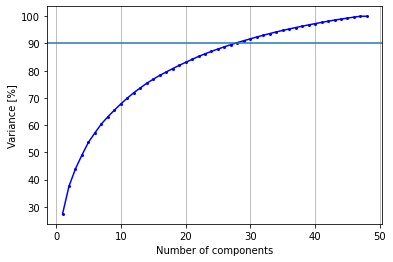

In [10]:
plot_cumulative_variance(np.cumsum(ssam_obj.pca_object.explained_variance_ratio_), 0.9)

Now the interesting part. We visualise the first three principal components, where the points are coloured by their displacement. 

explained variance is 0.27403606371886663


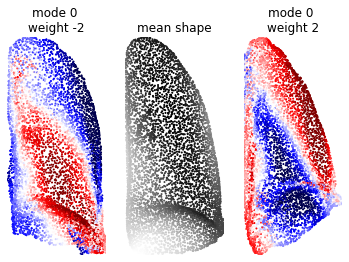

explained variance is 0.27403606371886663


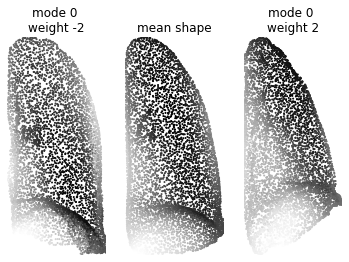

In [11]:
mode_to_plot = 0

plot_ssam_modes(
    mean_shape_appearance_columnvector, 
    mean_shape, 
    ssam_obj.model_parameters,
    ssam_obj.pca_model_components,
    mode_to_plot=mode_to_plot,
)
plot_ssam_modes(
    mean_shape_appearance_columnvector, 
    mean_shape, 
    ssam_obj.model_parameters,
    ssam_obj.pca_model_components,
    show_difference=False,
    mode_to_plot=mode_to_plot,
)

explained variance is 0.10199336940057738


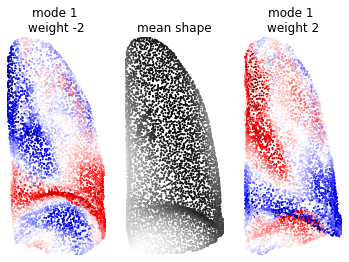

explained variance is 0.10199336940057738


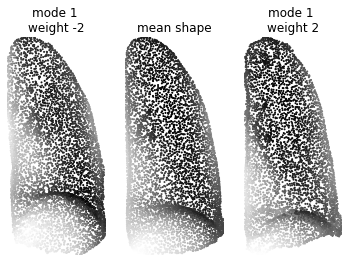

In [12]:
mode_to_plot = 1

plot_ssam_modes(
    mean_shape_appearance_columnvector, 
    mean_shape, 
    ssam_obj.model_parameters,
    ssam_obj.pca_model_components,
    mode_to_plot=mode_to_plot,
)
plot_ssam_modes(
    mean_shape_appearance_columnvector, 
    mean_shape, 
    ssam_obj.model_parameters,
    ssam_obj.pca_model_components,
    show_difference=False,
    mode_to_plot=mode_to_plot,
)

explained variance is 0.06396590938304693


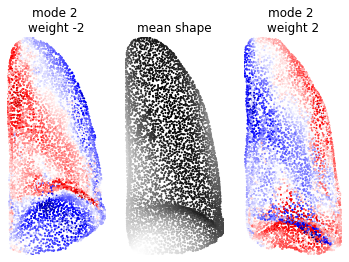

explained variance is 0.06396590938304693


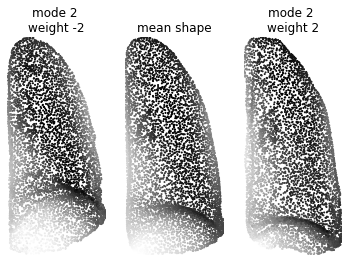

In [13]:
mode_to_plot = 2

plot_ssam_modes(
    mean_shape_appearance_columnvector, 
    mean_shape, 
    ssam_obj.model_parameters,
    ssam_obj.pca_model_components,
    mode_to_plot=mode_to_plot,
)
plot_ssam_modes(
    mean_shape_appearance_columnvector, 
    mean_shape, 
    ssam_obj.model_parameters,
    ssam_obj.pca_model_components,
    show_difference=False,
    mode_to_plot=mode_to_plot,
)

When we look at the 15th mode, which accounts for around 1% for the total variance, we can see a very minor change in the lung structure

explained variance is 0.014082077705233275


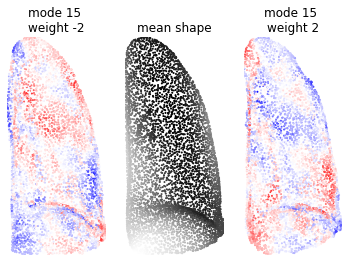

explained variance is 0.014082077705233275


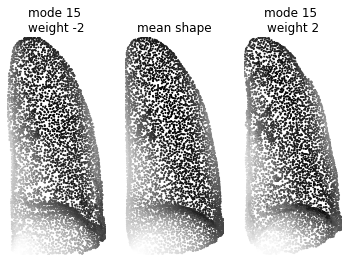

In [14]:
mode_to_plot = 15

plot_ssam_modes(
    mean_shape_appearance_columnvector, 
    mean_shape, 
    ssam_obj.model_parameters,
    ssam_obj.pca_model_components,
    mode_to_plot=mode_to_plot,
)
plot_ssam_modes(
    mean_shape_appearance_columnvector, 
    mean_shape, 
    ssam_obj.model_parameters,
    ssam_obj.pca_model_components,
    show_difference=False,
    mode_to_plot=mode_to_plot,
)